In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
pd.set_option("mode.copy_on_write", True)

In [2]:
#####################################################
# QQQ DATA AND CALCULATING PORTFOLIO VALUE AND DELTA
#####################################################

# Step 1: Get QQQ daily Prices
qqq_daily = yf.download('QQQ', start='2018-01-01', end='2023-12-31', interval='1d') # Download QQQ historical data

# Step 2: Calculate Daily Portfolio Value (will be useful for PNL)
initial_investment = 10_000_000 # $10M invested in the portfolio

# Pick the starting price (first Close price)
start_price = qqq_daily['Close'].iloc[0].item()

# Calculate Daily Portfolio Value
qqq_daily['Portfolio_Value'] = initial_investment  * (qqq_daily['Close'] / start_price)

# Step 3: Calculate Daily Portfolio Delta: will stay the same unless we do volatlity targeting, that will change

# Calculate number of shares bought on Day 1: Number of shares you bought at the beginning
num_shares = initial_investment / start_price
print(f"Number of QQQ shares bought at start: {num_shares}")

# Since delta per share ≈ +1, portfolio delta = number of shares
# Create a new column for Portfolio Delta
qqq_daily['Portfolio_Delta'] = num_shares
qqq_daily['Portfolio_Delta'] = qqq_daily['Portfolio_Delta'].ffill()

qqq_daily.columns = qqq_daily.columns.get_level_values(-2) # remove ticker qqq row

# # Drop unnecessary columns
qqq_daily_clean = qqq_daily[['Close', 'Portfolio_Value', 'Portfolio_Delta']]

# Check the first few rows
qqq_daily_clean.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Number of QQQ shares bought at start: 66247.40437663898


Price,Close,Portfolio_Value,Portfolio_Delta
Date,,,
2018-01-02,150.949310,1.000000e+07,66247.404377
2018-01-03,152.416016,1.009717e+07,66247.404377
2018-01-04,152.682724,1.011483e+07,66247.404377
2018-01-05,154.216095,1.021642e+07,66247.404377
2018-01-08,154.816132,1.025617e+07,66247.404377


In [3]:
#####################################################
# OPTIONS DATA
#####################################################


options_data = pd.read_csv("/Users/nzaramakouadio/Documents/Duke Classes/Spring 2025/RISK/583_RiskManagement_Final_Project/Data/qqq_option_data_2018_2023.csv")

# Columns we want to keep
columns_to_keep = ['date', 'exdate', 'cp_flag', 'strike_price', 'delta', 'gamma', 'best_bid', 'best_offer']
# best_bid and best_offer are good to calculate hedge cost later on / maybe keep impl_volatility not sure if needed for gamma hedging

# Keep only those columns
options_data = options_data[columns_to_keep].copy()

# Rename 'delta' to 'delta_option' to avoid confusion
options_data.rename(columns={'delta': 'delta_option', 'gamma':'gamma_option', 'strike_price': 'strike_price_option', 'exdate':'expiration_date_option'}, inplace=True)

# Divide strike price to get it's good version

options_data["strike_price_option"] = options_data["strike_price_option"] / 1_000

# Check the first few rows to make sure
options_data.head()


/var/folders/_5/g20j99hd5j91r849_d_zgb040000gn/T/ipykernel_1454/1198056029.py:6: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  options_data = pd.read_csv("/Users/nzaramakouadio/Documents/Duke Classes/Spring 2025/RISK/583_RiskManagement_Final_Project/Data/qqq_option_data_2018_2023.csv")


,date,expiration_date_option,cp_flag,strike_price_option,delta_option,gamma_option,best_bid,best_offer
0,2018-01-02,2018-02-02,C,148.5,0.892498,0.021384,10.49,10.70
1,2018-01-02,2018-02-02,C,149.5,0.875178,0.024551,9.61,9.73
2,2018-01-02,2018-02-02,C,153.0,0.791621,0.039376,6.48,6.56
3,2018-01-02,2018-02-02,C,153.5,0.776244,0.042127,6.05,6.11
4,2018-01-02,2018-02-02,C,154.0,0.758090,0.044900,5.63,5.69


In [4]:
############################################################
# SELECTING ONLY ATM OPTIONS (BEST CHOICE FOR DELTA HEDGING)
###########################################################


# Step 1: Fix qqq_daily so 'date' becomes a normal column
qqq_daily = qqq_daily.reset_index()
qqq_daily['Date'] = pd.to_datetime(qqq_daily['Date'])  # Make sure it's datetime

# Step 2: Fix options_data_clean 'date'
options_data['date'] = pd.to_datetime(options_data['date'])

# Step 3: NOW merge safely
options_merged = options_data.merge(
    qqq_daily[['Date', 'Close']],   # Only Date and Close from qqq_daily
    left_on='date', 
    right_on='Date', 
    how='left'
)

# Step 4: Drop duplicate 'Date' column (optional, for neatness)
options_merged = options_merged.drop(columns=['Date'])

# Step 5: Calculate absolute difference between strike and close
options_merged['abs_diff'] = abs(options_merged['strike_price_option'] - options_merged['Close'])

# Step: Pick the ATM Call and ATM Put for each day

# For each day and each cp_flag (C or P), find the row with the minimum abs_diff
atm_options = options_merged.loc[
    options_merged.groupby(['date', 'cp_flag'])['abs_diff'].idxmin()
]

# Reset index to clean up
atm_options = atm_options.reset_index(drop=True)

# Check the first few rows
atm_options.head(15)





,date,expiration_date_option,cp_flag,strike_price_option,delta_option,gamma_option,best_bid,best_offer,Close,abs_diff
0,2018-01-02,2018-02-16,C,151.0,0.805469,0.028913,8.69,8.85,150.949310,0.050690
1,2018-01-02,2018-02-02,P,151.0,-0.155857,0.030206,0.65,0.67,150.949310,0.050690
2,2018-01-03,2018-02-02,C,152.0,0.869227,0.027812,8.59,8.77,152.416016,0.416016
3,2018-01-03,2018-02-02,P,152.5,-0.141354,0.030022,0.54,0.56,152.416016,0.083984
4,2018-01-04,2018-02-02,C,153.0,0.865481,0.030552,7.94,8.04,152.682724,0.317276
5,2018-01-04,2018-02-02,P,152.5,-0.125177,0.028408,0.45,0.47,152.682724,0.182724
6,2018-01-05,2018-02-02,C,154.0,0.879281,0.027904,8.44,8.55,154.216095,0.216095
7,2018-01-05,2018-02-02,P,154.0,-0.123792,0.028103,0.45,0.46,154.216095,0.216095
8,2018-01-08,2018-02-02,C,155.0,0.880616,0.029256,8.05,8.15,154.816132,0.183868
9,2018-01-08,2018-02-02,P,155.0,-0.121730,0.029442,0.41,0.43,154.816132,0.183868


In [5]:
############################################################
# CLEAN UP ATM_OPTIONS DATA TO HAVE 1 COLUMN FOR CALL AND 1 COLUMN FOR PUT 
###########################################################

# Step 1: Pivot atm_options
# Separate Call and Put columns by renaming before pivoting

# First, create a new column to label the call/put side
atm_options['option_type'] = atm_options['cp_flag'].map({'C': 'call', 'P': 'put'})

# Now pivot so that call and put data are side-by-side
atm_options_pivot = atm_options.pivot(index='date', columns='option_type')

# Step 2: Flatten multi-level column names
atm_options_pivot.columns = [f"{col[1]}_{col[0]}" for col in atm_options_pivot.columns]

# Step 3: Reset index so 'date' is a normal column again
atm_options_pivot = atm_options_pivot.reset_index()

# Columns to drop
columns_to_drop_atm = [
    'call_cp_flag', 'put_cp_flag',
    'call_abs_diff', 'put_abs_diff',
    'call_Close', 'put_Close'
]

# Drop them
atm_options_clean = atm_options_pivot.drop(columns=columns_to_drop_atm)

# Check the cleaned pivot

atm_options_clean.head(10)


,date,call_expiration_date_option,put_expiration_date_option,call_strike_price_option,put_strike_price_option,call_delta_option,put_delta_option,call_gamma_option,put_gamma_option,call_best_bid,put_best_bid,call_best_offer,put_best_offer
0,2018-01-02,2018-02-16,2018-02-02,151.0,151.0,0.805469,-0.155857,0.028913,0.030206,8.69,0.65,8.85,0.67
1,2018-01-03,2018-02-02,2018-02-02,152.0,152.5,0.869227,-0.141354,0.027812,0.030022,8.59,0.54,8.77,0.56
2,2018-01-04,2018-02-02,2018-02-02,153.0,152.5,0.865481,-0.125177,0.030552,0.028408,7.94,0.45,8.04,0.47
3,2018-01-05,2018-02-02,2018-02-02,154.0,154.0,0.879281,-0.123792,0.027904,0.028103,8.44,0.45,8.55,0.46
4,2018-01-08,2018-02-02,2018-02-02,155.0,155.0,0.880616,-0.121730,0.029256,0.029442,8.05,0.41,8.15,0.43
5,2018-01-09,2018-02-09,2018-02-09,155.0,155.0,0.846635,-0.150013,0.029755,0.029867,8.28,0.61,8.50,0.63
6,2018-01-10,2018-02-16,2018-02-09,154.0,154.5,0.838486,-0.151932,0.027283,0.029431,9.10,0.64,9.25,0.65
7,2018-01-11,2018-02-16,2018-02-23,156.0,155.5,0.826013,-0.180502,0.030629,0.028446,8.24,0.90,8.31,0.96
8,2018-01-12,2018-02-23,2018-02-09,156.5,156.5,0.828397,-0.133028,0.027941,0.028251,8.90,0.51,9.14,0.53
9,2018-01-16,2018-02-23,2018-02-16,156.0,156.0,0.820945,-0.161702,0.027401,0.028007,9.13,0.76,9.33,0.77


In [6]:
############################################################
# MERGE QQQ_DAILY_CLEAN AND ATM_OPTIONS_CLEAN
###########################################################

final_merged_data = qqq_daily_clean.merge(
    atm_options_clean,
    left_on='Date',  # column name in qqq_daily_clean
    right_on='date',  # column name in atm_options_clean
    how='inner'      # only keep dates that match
)


# Convert expiration date into date

final_merged_data['call_expiration_date_option'] = pd.to_datetime(final_merged_data['call_expiration_date_option'])
final_merged_data['put_expiration_date_option'] = pd.to_datetime(final_merged_data['put_expiration_date_option'])

# Check the final merged dataset
final_merged_data.head()



,Close,Portfolio_Value,Portfolio_Delta,date,call_expiration_date_option,put_expiration_date_option,call_strike_price_option,put_strike_price_option,call_delta_option,put_delta_option,call_gamma_option,put_gamma_option,call_best_bid,put_best_bid,call_best_offer,put_best_offer
0,150.949310,1.000000e+07,66247.404377,2018-01-02,2018-02-16,2018-02-02,151.0,151.0,0.805469,-0.155857,0.028913,0.030206,8.69,0.65,8.85,0.67
1,152.416016,1.009717e+07,66247.404377,2018-01-03,2018-02-02,2018-02-02,152.0,152.5,0.869227,-0.141354,0.027812,0.030022,8.59,0.54,8.77,0.56
2,152.682724,1.011483e+07,66247.404377,2018-01-04,2018-02-02,2018-02-02,153.0,152.5,0.865481,-0.125177,0.030552,0.028408,7.94,0.45,8.04,0.47
3,154.216095,1.021642e+07,66247.404377,2018-01-05,2018-02-02,2018-02-02,154.0,154.0,0.879281,-0.123792,0.027904,0.028103,8.44,0.45,8.55,0.46
4,154.816132,1.025617e+07,66247.404377,2018-01-08,2018-02-02,2018-02-02,155.0,155.0,0.880616,-0.121730,0.029256,0.029442,8.05,0.41,8.15,0.43


In [7]:
##########################################################
# ADD PNL DATA HELP US SEE EFFECTIVENESS OF OUR HEDGE
#########################################################

# Calculate daily portfolio PnL
final_merged_data['Portfolio_PnL'] = final_merged_data['Portfolio_Value'].diff()

# First day will be NaN (because no previous day), so you can fill it with 0
final_merged_data['Portfolio_PnL'] = final_merged_data['Portfolio_PnL'].fillna(0)


In [8]:
###############################################
# DELTA HEDGING (WITH DYNAMIC LAYERING)
###############################################

# Step 1: Set your tolerance band for net delta
# and your dynamic trigger for market drop

tolerance_band = 5_00    # Hedge if Net Delta > +/-500
market_drop_trigger = 0.05 # Hedge if market drops more than 5% from peak (dynamic trigger)

# Step 2: Create an empty list to store hedge actions
hedge_actions = []

# Step 3: Start with NO hedge position
current_hedge_positions = []  # List of active hedges
current_hedge_delta = 0       # Total hedge delta

# Step 4: Track recent peak price to measure drops
recent_peak = final_merged_data['Close'].iloc[0]

# Step 5: Loop through each day
for idx, row in final_merged_data.iterrows():
    portfolio_delta = row['Portfolio_Delta']
    net_delta = portfolio_delta - current_hedge_delta

    action = 'No hedge'
    contracts_to_trade = 0
    option_used = None

    # Update recent peak if we hit a new high
    if row['Close'] > recent_peak:
        recent_peak = row['Close']

    # Calculate market drawdown
    drawdown = (recent_peak - row['Close']) / recent_peak

    ## Check if any existing hedges expire
    if len(current_hedge_positions) > 0:
        still_valid_hedges = []
        for hedge in current_hedge_positions:
            if row['date'] < hedge['expiration']:
                still_valid_hedges.append(hedge)
            else:
                current_hedge_delta -= hedge['contracts'] * hedge['option_delta'] * 100
        current_hedge_positions = still_valid_hedges

    ## --- MAIN CHANGE: Only hedge if market dropped enough --- ##
    if drawdown >= market_drop_trigger:

        # Check if net delta is outside the tolerance band
        if abs(net_delta) > tolerance_band:

            if net_delta > 0:
                # Too positive = need to buy PUTS
                option_delta = row['put_delta_option']
                if abs(option_delta) > 1e-6:
                    contracts_to_trade = round(net_delta / (option_delta * 100))
                    current_hedge_delta += contracts_to_trade * option_delta * 100
                    action = f"BUY {contracts_to_trade} puts"
                    option_used = 'put'
                    current_hedge_positions.append({
                        'contracts': contracts_to_trade,
                        'option_delta': option_delta,
                        'expiration': row['put_expiration_date_option']
                    })
            else:
                # Too negative = need to sell CALLS
                option_delta = row['call_delta_option']
                if abs(option_delta) > 1e-6:
                    contracts_to_trade = round(net_delta / (option_delta * 100))
                    current_hedge_delta += contracts_to_trade * option_delta * 100
                    action = f"SELL {contracts_to_trade} calls"
                    option_used = 'call'
                    current_hedge_positions.append({
                        'contracts': contracts_to_trade,
                        'option_delta': option_delta,
                        'expiration': row['call_expiration_date_option']
                    })

    # Step 6: Save today's information
    hedge_actions.append({
        'Date': row['date'],
        'Portfolio_Delta': portfolio_delta,
        'Current_Hedge_Delta': current_hedge_delta,
        'Net_Delta': portfolio_delta - current_hedge_delta,
        'Action': action,
        'Contracts_Traded': contracts_to_trade,
        'Option_Used': option_used
    })

# Step 7: Convert the actions into a DataFrame
hedge_actions = pd.DataFrame(hedge_actions)

# Step 8: Check the result
hedge_actions.head(60)


,Date,Portfolio_Delta,Current_Hedge_Delta,Net_Delta,Action,Contracts_Traded,Option_Used
0,2018-01-02,66247.404377,0.0000,66247.404377,No hedge,0,None
1,2018-01-03,66247.404377,0.0000,66247.404377,No hedge,0,None
2,2018-01-04,66247.404377,0.0000,66247.404377,No hedge,0,None
3,2018-01-05,66247.404377,0.0000,66247.404377,No hedge,0,None
4,2018-01-08,66247.404377,0.0000,66247.404377,No hedge,0,None
5,2018-01-09,66247.404377,0.0000,66247.404377,No hedge,0,None
6,2018-01-10,66247.404377,0.0000,66247.404377,No hedge,0,None
7,2018-01-11,66247.404377,0.0000,66247.404377,No hedge,0,None
8,2018-01-12,66247.404377,0.0000,66247.404377,No hedge,0,None
9,2018-01-16,66247.404377,0.0000,66247.404377,No hedge,0,None


In [9]:
hedge_actions["Option_Used"].value_counts()

Option_Used
put    39
Name: count, dtype: int64

In [10]:
###############################################
# ADD HEDGE PNL (Corrected Version)
###############################################

# Step 1: Create an empty list to store the daily Hedge PnL
hedge_pnl_list = []

# Step 2: Initialize a list to keep track of active hedges (open hedges)
active_hedges = []

# Step 3: Loop through each day in the final merged data
for idx, row in final_merged_data.iterrows():
    daily_hedge_pnl = 0  # Reset today's hedge PnL to zero

    # Step 4: Check if a new hedge was added today
    matching_hedges = hedge_actions[
        (hedge_actions['Date'] == row['date']) & (hedge_actions['Action'] != 'No hedge')
    ]

    # Step 5: If yes, add the new hedge into our active hedges list
    for _, hedge_row in matching_hedges.iterrows():
        hedge = {
            'option_used': hedge_row['Option_Used'],      # 'put' or 'call'
            'contracts': hedge_row['Contracts_Traded'],   # How many contracts we bought
            'strike_price': row['put_strike_price_option'] if hedge_row['Option_Used'] == 'put' else row['call_strike_price_option'],
            'initial_bid': row['put_best_bid'] if hedge_row['Option_Used'] == 'put' else row['call_best_bid'],
            'expiration': row['put_expiration_date_option'] if hedge_row['Option_Used'] == 'put' else row['call_expiration_date_option']
        }
        active_hedges.append(hedge)

    # Step 6: Calculate today's total Hedge PnL from all active hedges
    updated_hedges = []  # Temporary list to store still-active hedges
    for hedge in active_hedges:
        if row['date'] < hedge['expiration']:
            # Hedge is still active
            if hedge['option_used'] == 'put':
                current_price = row['put_best_bid']
            else:
                current_price = row['call_best_bid']

            # PnL = (Current option price - initial price) × number of contracts × 100 (because each option controls 100 shares)
            pnl = hedge['contracts'] * (current_price - hedge['initial_bid']) * 100
            daily_hedge_pnl += pnl

            updated_hedges.append(hedge)
        else:
            # Hedge expired -> we stop tracking it
            pass

    # Update active hedges list for tomorrow
    active_hedges = updated_hedges

    # Step 7: Save today's total Hedge PnL
    hedge_pnl_list.append(daily_hedge_pnl)

# Step 8: After looping through all dates, add the hedge PnL to the main dataframe
final_merged_data['Hedge_PnL'] = hedge_pnl_list

# Step 9: Create a new Net PnL column (Portfolio PnL + Hedge PnL)
final_merged_data['Net_PnL'] = final_merged_data['Portfolio_PnL'] + final_merged_data['Hedge_PnL']


final_merged_data.head()

,Close,Portfolio_Value,Portfolio_Delta,date,call_expiration_date_option,put_expiration_date_option,call_strike_price_option,put_strike_price_option,call_delta_option,put_delta_option,call_gamma_option,put_gamma_option,call_best_bid,put_best_bid,call_best_offer,put_best_offer,Portfolio_PnL,Hedge_PnL,Net_PnL
0,150.949310,1.000000e+07,66247.404377,2018-01-02,2018-02-16,2018-02-02,151.0,151.0,0.805469,-0.155857,0.028913,0.030206,8.69,0.65,8.85,0.67,0.000000,0.0,0.000000
1,152.416016,1.009717e+07,66247.404377,2018-01-03,2018-02-02,2018-02-02,152.0,152.5,0.869227,-0.141354,0.027812,0.030022,8.59,0.54,8.77,0.56,97165.420585,0.0,97165.420585
2,152.682724,1.011483e+07,66247.404377,2018-01-04,2018-02-02,2018-02-02,153.0,152.5,0.865481,-0.125177,0.030552,0.028408,7.94,0.45,8.04,0.47,17668.737505,0.0,17668.737505
3,154.216095,1.021642e+07,66247.404377,2018-01-05,2018-02-02,2018-02-02,154.0,154.0,0.879281,-0.123792,0.027904,0.028103,8.44,0.45,8.55,0.46,101581.846820,0.0,101581.846820
4,154.816132,1.025617e+07,66247.404377,2018-01-08,2018-02-02,2018-02-02,155.0,155.0,0.880616,-0.121730,0.029256,0.029442,8.05,0.41,8.15,0.43,39750.868678,0.0,39750.868678


In [11]:
##############################################
# DID OUR STRATEGY WORK?
#############################################

# Calculate overall sums
total_portfolio_pnl = final_merged_data['Portfolio_PnL'].sum()
total_net_pnl = final_merged_data['Net_PnL'].sum()

# Print results
print(f"Total Portfolio PnL (unhedged): ${total_portfolio_pnl:.2f}")
print(f"Total Net PnL (with hedge): ${total_net_pnl:.2f}")

# Final conclusion
if total_net_pnl > total_portfolio_pnl:
    print("Hedge HELPED! Net PnL is better :)")
else:
    print("Hedge did NOT help Net PnL :(")


##############################################
# PLOT OPTIONAL
#############################################


Total Portfolio PnL (unhedged): $14757434.18
Total Net PnL (with hedge): $92215052.18
Hedge HELPED! Net PnL is better :)


## STOP HERE ##

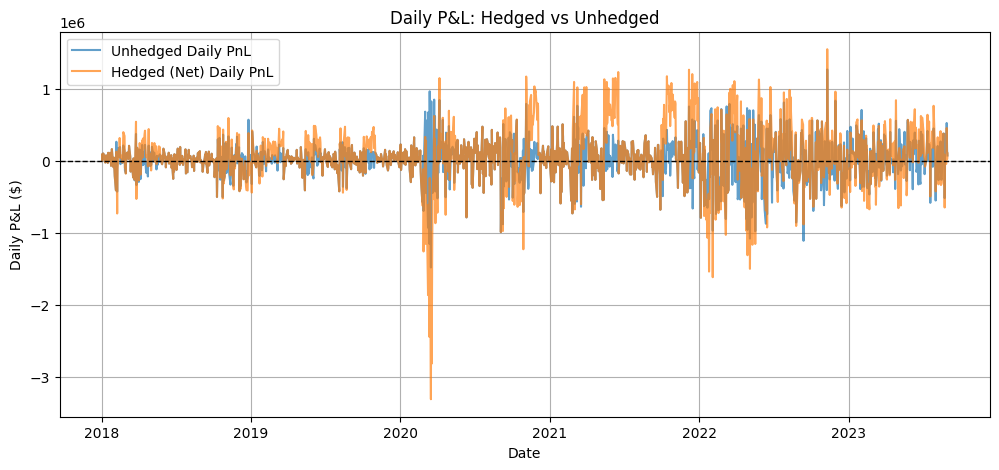

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the plotting DataFrame
plot_df = (
    final_merged_data
    .loc[:, ['date','Portfolio_PnL','Net_PnL']]
    .dropna()
    .copy()
)
plot_df['date'] = pd.to_datetime(plot_df['date'])

# Extract as 1-D arrays
x   = plot_df['date'].to_numpy()
y1  = plot_df['Portfolio_PnL'].to_numpy()
y2  = plot_df['Net_PnL'].to_numpy()

# Plot daily PnL
plt.figure(figsize=(12,5))
plt.plot(x, y1, label='Unhedged Daily PnL', alpha=0.7)
plt.plot(x, y2, label='Hedged (Net) Daily PnL', alpha=0.7)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title('Daily P&L: Hedged vs Unhedged')
plt.xlabel('Date')
plt.ylabel('Daily P&L ($)')
plt.legend()
plt.grid(True)
plt.show()


x: (1426,) y1: (1426,) y2: (1426,)


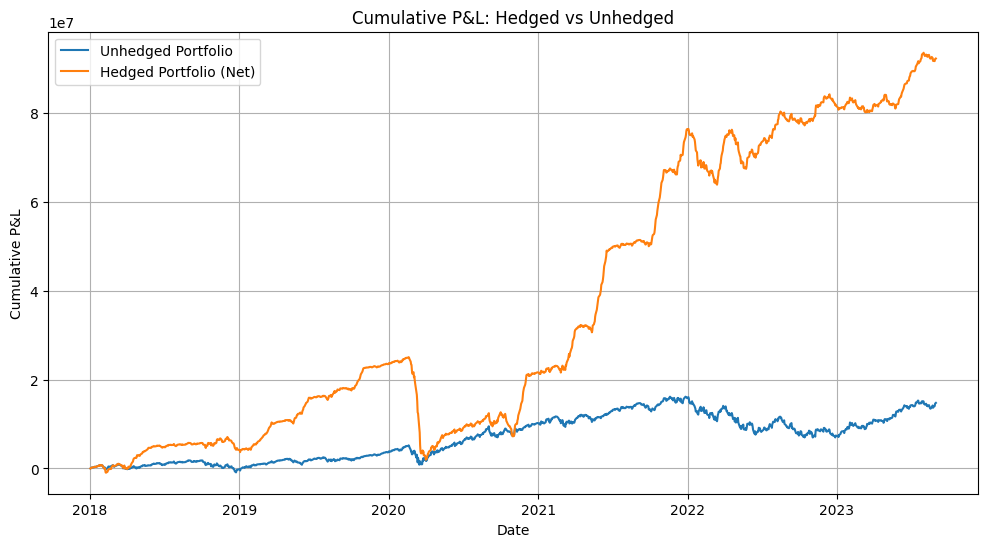

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Coerce to numeric & drop any bad rows
final_merged_data['Portfolio_PnL'] = pd.to_numeric(final_merged_data['Portfolio_PnL'], errors='coerce')
final_merged_data['Net_PnL']       = pd.to_numeric(final_merged_data['Net_PnL'],       errors='coerce')

plot_df = (
    final_merged_data
    .loc[:, ['date','Portfolio_PnL','Net_PnL']]
    .dropna()
    .copy()
)

# 2) Make sure date is datetime
plot_df['date'] = pd.to_datetime(plot_df['date'])

# 3) Compute cumulative P&L
plot_df['Cum_Unhedged'] = plot_df['Portfolio_PnL'].cumsum()
plot_df['Cum_Hedged']   = plot_df['Net_PnL'].cumsum()

# 4) Convert to plain numpy arrays
x  = plot_df['date'].to_numpy()
y1 = plot_df['Cum_Unhedged'].to_numpy()
y2 = plot_df['Cum_Hedged'].to_numpy()

# (Optional) sanity-check shapes
print("x:", x.shape, "y1:", y1.shape, "y2:", y2.shape)

# 5) Plot
plt.figure(figsize=(12,6))
plt.plot(x, y1, label='Unhedged Portfolio')
plt.plot(x, y2, label='Hedged Portfolio (Net)')
plt.title('Cumulative P&L: Hedged vs Unhedged')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.grid(True)
plt.show()




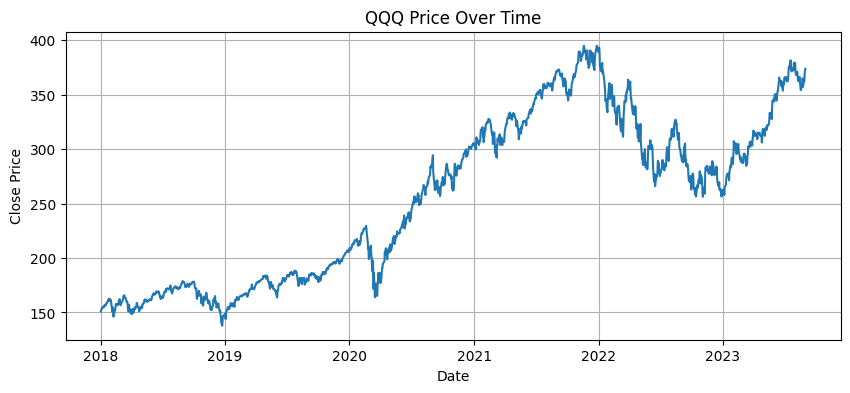

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# make sure your date column is datetime
final_merged_data['date'] = pd.to_datetime(final_merged_data['date'])

# pull out NumPy arrays
x = final_merged_data['date'].to_numpy()
y = final_merged_data['Close'].to_numpy()

plt.figure(figsize=(10, 4))
plt.plot(x, y)
plt.title('QQQ Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid()
plt.show()
